In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [39]:
train_data = pd.read_csv("./datasets/titanic/train.csv")
test_data = pd.read_csv("./datasets/titanic/test.csv")

print(train_data.shape)
train_data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [41]:
train_data["Cabin"] = train_data["Cabin"].str[:1]
train_data["Cabin"].fillna("Na", inplace=True)

object_cols = train_data.columns[train_data.dtypes == object]
train_data[object_cols] = train_data[object_cols].astype("string")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    string 
 4   Sex          891 non-null    string 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    string 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    string 
 11  Embarked     889 non-null    string 
dtypes: float64(2), int64(5), string(5)
memory usage: 83.7 KB


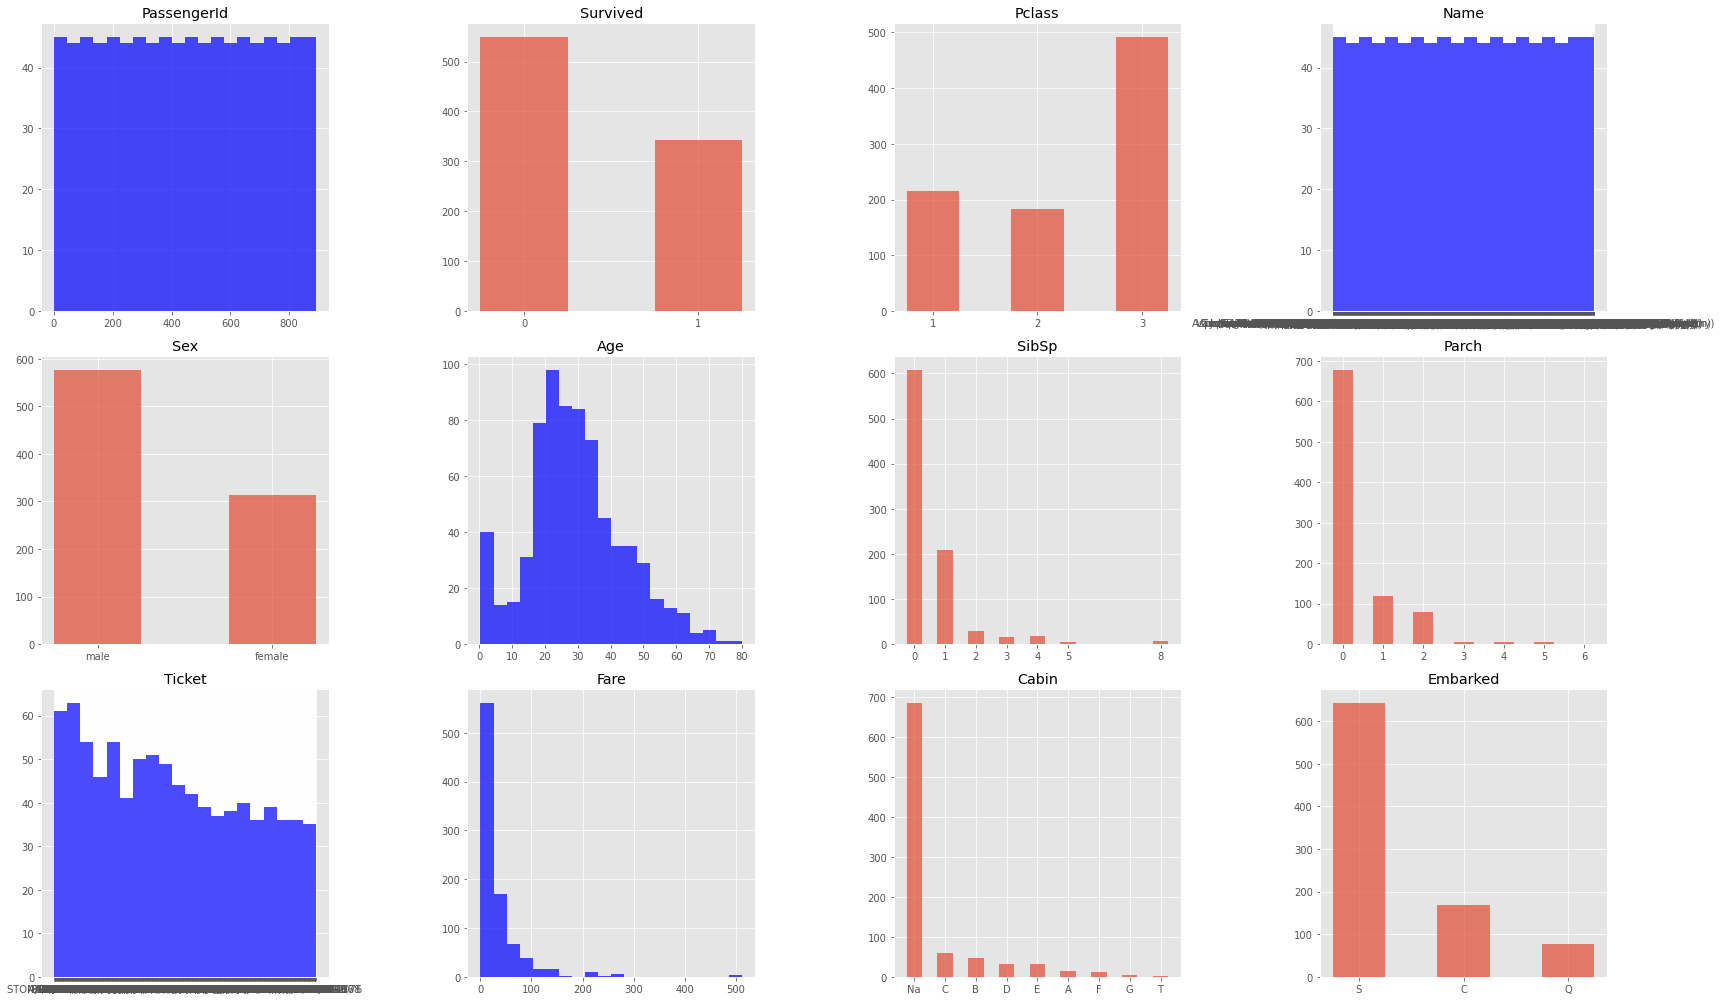

In [42]:
plt.style.use("ggplot")
plt.figure(figsize=(24,20))

cols = train_data.columns
for i in range(len(cols)):
    plt.subplot(4, 4, i+1)
    plt.title(cols[i])
    if len(train_data[cols[i]].unique()) > 20:
        plt.hist(train_data[cols[i]], bins=20, color="b", alpha=0.7)
    else:
        temp = train_data[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

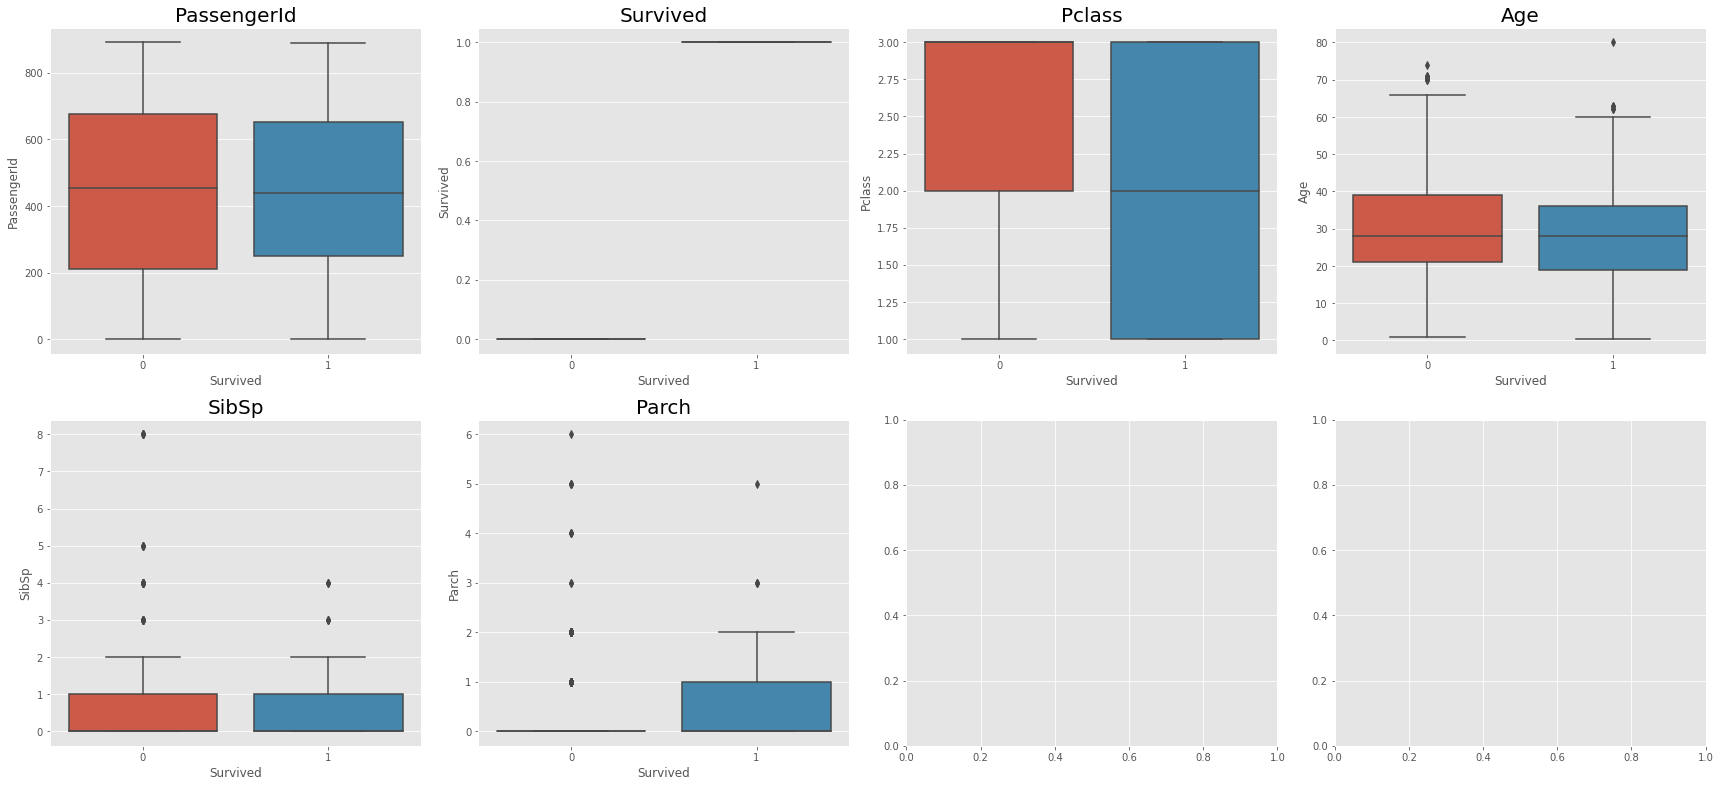

In [43]:
num_data = train_data[train_data.columns[(train_data.dtypes == "int64") | (train_data.dtypes == "float64")]]

fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for ax, col in zip(axes.flat, num_data.columns[:-1]):
    sns.boxplot(x="Survived", y=col, ax=ax, data=num_data)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1. PassengerId 불필요
2. Name특성 너무 많음
3. Age특성 너무 많음
4. Ticket특성 너무 많음
5. SibSp, Parch, Fare특성 너무 좌측편향됨
6. Age, Embarked 결측치

7. SibSp, Parch 이상

방법

1. PassengerId특성 제거
2. Name특성 First, Last로 분해
3. 쏠리지도 않고 괜찮은거같음
4. 미해결
5. 스케일링
6. Age - Pclass별로 나이 구분하여 결측치 해결, Embarked - 이름 같은 사람의 Embarked 복사

7. 합치거나 스케일링

In [44]:
numeric_feature = ["Age", "SibSp", "Parch", "Fare"]
ordinal_feature = ["Pclass"]
categorical_feature = ["Sex", "Cabin", "Embarked"]
too_many_feature = ["Name", "Ticket"]

# train_data["FirstName"], train_data["LastName"] = train_data.Name.str.split(",").str[0], train_data.Name.str.split(",").str[1]
# train_data.drop("Name", axis=1, inplace=True)

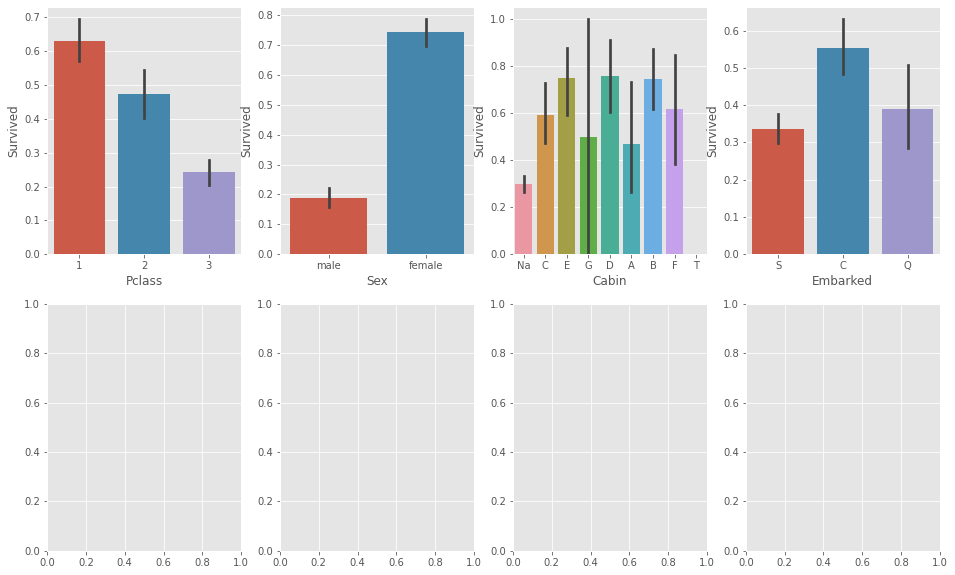

In [45]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))

feature = ordinal_feature + categorical_feature

xvalue = 0
yvalue = 0

for xstr in feature:
    sns.barplot(x=xstr, y="Survived", data=train_data, ax=ax[yvalue][xvalue])
    if xvalue == 3:
        xvalue = 0
        yvalue += 1
    else:
        xvalue += 1

In [46]:
train_data["Family"] = train_data["SibSp"].values + train_data["Parch"].values
numeric_feature.append("Family")

for xstr in numeric_feature:
    print(xstr, "Scew: ", train_data[xstr].skew())

Age Scew:  0.38910778230082704
SibSp Scew:  3.6953517271630565
Parch Scew:  2.7491170471010933
Fare Scew:  4.787316519674893
Family Scew:  2.7274414739308535


AttributeError: 'numpy.ndarray' object has no attribute 'xaxis'

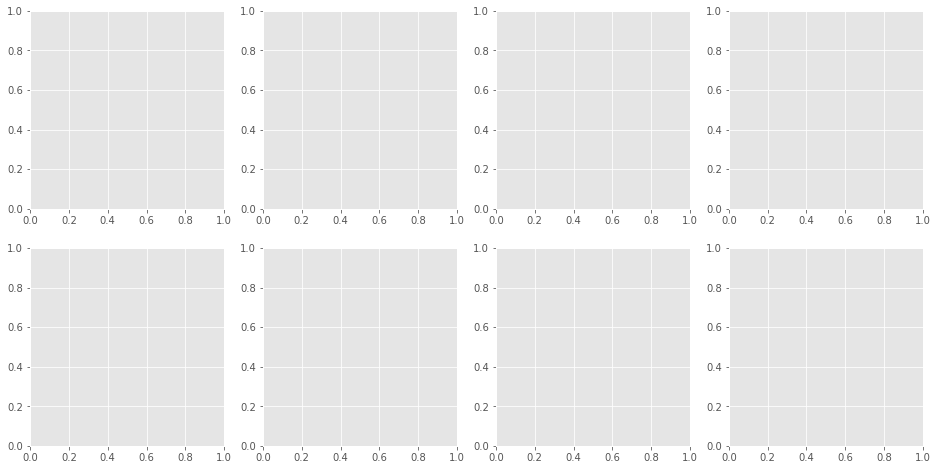

In [50]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

for xint in range(5):
    sns.kdeplot(x=numeric_feature[xint], data=train_data, ax=ax[xint])

In [ ]:
train_data